In [4]:
# Enhanced Trading Analyzer - Focused on Reversals and Band Dynamics
import pandas as pd
from datetime import date, datetime, timedelta
import requests
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuration constants
SYMBOL = "AAPL"
SEQUENCE_LENGTH = 20
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY', 'demo')

def calculate_reversal_features(df):
    """Calculate features that capture price reversals and band dynamics"""
    features_df = df.copy()
    
    # Price momentum and reversal indicators
    features_df['price_momentum'] = features_df['close'].pct_change(periods=3)
    features_df['price_acceleration'] = features_df['price_momentum'].diff()
    
    # Bollinger Band width and position
    features_df['band_width'] = (features_df['upper'] - features_df['lower']) / features_df['middle']
    features_df['band_width_change'] = features_df['band_width'].pct_change()
    features_df['price_position'] = (features_df['close'] - features_df['lower']) / (features_df['upper'] - features_df['lower'])
    
    # Reversal signals
    features_df['price_direction'] = np.where(features_df['close'].diff() > 0, 1, -1)
    features_df['direction_change'] = features_df['price_direction'].diff().abs()
    
    # Band squeeze/expansion
    features_df['band_squeeze'] = features_df['band_width'].rolling(10).min() == features_df['band_width']
    features_df['band_expansion'] = features_df['band_width'].rolling(5).max() == features_df['band_width']
    
    # Moving averages for trend detection
    features_df['ma_5'] = features_df['close'].rolling(5).mean()
    features_df['ma_10'] = features_df['close'].rolling(10).mean()
    features_df['ma_cross'] = np.where(features_df['ma_5'] > features_df['ma_10'], 1, -1)
    features_df['ma_cross_change'] = features_df['ma_cross'].diff().abs()
    
    # Volatility indicators
    features_df['volatility'] = features_df['close'].rolling(10).std()
    features_df['volatility_change'] = features_df['volatility'].pct_change()
    
    return features_df

def detect_statistical_anomalies(features_df):
    """Simple statistical anomaly detection focused on reversals"""
    # Key features for reversal detection
    key_features = [
        'price_momentum', 'price_acceleration', 'band_width_change',
        'price_position', 'direction_change', 'ma_cross_change',
        'volatility_change'
    ]
    
    # Ensure all features exist and handle missing values
    for feature in key_features:
        if feature not in features_df.columns:
            features_df[feature] = 0
    
    # Calculate composite anomaly score
    anomaly_scores = np.zeros(len(features_df))
    
    for feature in key_features:
        data = features_df[feature].fillna(0)
        
        # Use rolling statistics for dynamic thresholds
        rolling_mean = data.rolling(window=20, min_periods=5).mean()
        rolling_std = data.rolling(window=20, min_periods=5).std()
        
        # Z-score based anomaly detection
        z_scores = np.abs((data - rolling_mean) / (rolling_std + 1e-6))
        
        # Weight different features
        if 'direction_change' in feature or 'ma_cross_change' in feature:
            weight = 2.0  # Higher weight for direction changes
        elif 'band_width_change' in feature:
            weight = 1.5  # Medium weight for band changes
        else:
            weight = 1.0  # Standard weight
            
        anomaly_scores += (z_scores > 2.0).astype(float) * weight
    
    # Normalize scores
    max_possible_score = sum([2.0 if 'change' in f else 1.0 for f in key_features])
    anomaly_scores = anomaly_scores / max_possible_score
    
    return anomaly_scores

class EnhancedTradingAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key

    def fetch_bollinger_bands(self, symbol, interval):
        """Fetch Bollinger Bands data with timeout"""
        print(f"⬇️ Fetching data for {symbol} ({interval})...")
        try:
            bbands_params = {
                "function": "BBANDS",
                "symbol": symbol,
                "interval": interval,
                "time_period": 20,
                "series_type": "close",
                "apikey": self.api_key
            }
            response = requests.get("https://www.alphavantage.co/query", params=bbands_params, timeout=20)
            data = response.json()

            if 'Technical Analysis: BBANDS' not in data:
                print(f"❌ API Error: {data.get('Note', 'No BBANDS data found.')}")
                return None

            df = pd.DataFrame.from_dict(data['Technical Analysis: BBANDS'], orient='index')
            df.columns = ['upper', 'middle', 'lower']
            df = df.apply(pd.to_numeric, errors='coerce')
            df.index = pd.to_datetime(df.index)

            price_params = {
                "function": "TIME_SERIES_INTRADAY",
                "symbol": symbol,
                "interval": interval,
                "apikey": self.api_key,
                "outputsize": "full"
            }
            price_response = requests.get("https://www.alphavantage.co/query", params=price_params, timeout=20)
            price_response_data = price_response.json()
            
            time_series_key = f'Time Series ({interval})'
            if time_series_key not in price_response_data:
                print(f"❌ Price data not available: {price_response_data.get('Note', 'Unknown error')}")
                return None
                
            price_data = price_response_data[time_series_key]
            price_df = pd.DataFrame.from_dict(price_data, orient='index')['4. close']
            price_df.index = pd.to_datetime(price_df.index)
            price_df = price_df.astype(float)
            price_df.name = 'close'
            
            df = df.join(price_df).dropna()
            return df.sort_index()
            
        except requests.exceptions.Timeout:
            print("❌ API request timed out. The server is not responding.")
            return None
        except Exception as e:
            print(f"❌ An error occurred during data fetching: {e}")
            return None

    def generate_mock_data(self, days=60):
        """Generate realistic mock data with clear reversal patterns"""
        print("🎭 Generating mock data with reversal patterns...")
        dates = pd.date_range(end=datetime.now(), periods=days*24, freq='H')
        
        np.random.seed(42)
        base_price = 150
        
        # Create more realistic price with trend changes
        price_series = []
        current_price = base_price
        trend = 1
        
        for i, date in enumerate(dates):
            if i > 0 and i % 200 == 0:  # Change trend every ~200 periods
                trend *= -1  # Reverse trend
                
            # Add trend and noise
            price_change = np.random.normal(trend * 0.001, 0.015)
            current_price *= (1 + price_change)
            price_series.append(current_price)
        
        df = pd.DataFrame(index=dates, data={'close': price_series})
        df['middle'] = df['close'].rolling(20).mean()
        df['std'] = df['close'].rolling(20).std()
        df['upper'] = df['middle'] + (2 * df['std'])
        df['lower'] = df['middle'] - (2 * df['std'])
        
        return df[['upper', 'middle', 'lower', 'close']].dropna()

    def detect_reversal_anomalies(self, df):
        """Detect anomalies focused on reversals and band dynamics"""
        required_cols = ['upper', 'middle', 'lower', 'close']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Missing required columns: {missing_cols}")
            df['anomaly'] = False
            df['anomaly_score'] = 0.0
            df['reversal_signal'] = 'None'
            return df
        
        # Calculate enhanced features
        features_df = calculate_reversal_features(df)
        
        # Use statistical anomaly detection
        print("🔍 Running statistical reversal anomaly detection...")
        anomaly_scores = detect_statistical_anomalies(features_df)
        
        # Set threshold (top 10% of scores)
        threshold = np.percentile(anomaly_scores[anomaly_scores > 0], 85)
        
        df['anomaly_score'] = anomaly_scores
        df['anomaly'] = df['anomaly_score'] > threshold
        
        # Add reversal signal classification
        df = self.classify_reversal_signals(df, features_df)
        
        print(f"🔎 Reversal anomaly detection complete. Threshold: {threshold:.4f}")
        print(f"📊 Found {df['anomaly'].sum()} reversal anomalies out of {len(df)} data points")
        
        return df
    
    def classify_reversal_signals(self, df, features_df):
        """Classify the type of reversal signal"""
        df['reversal_signal'] = 'None'
        
        for i in range(len(df)):
            if df['anomaly'].iloc[i]:
                if i < len(features_df):
                    band_expanding = features_df['band_width_change'].iloc[i] > 0.02
                    band_contracting = features_df['band_width_change'].iloc[i] < -0.02
                    direction_change = features_df['direction_change'].iloc[i] > 0
                    high_volatility = features_df.get('volatility_change', pd.Series([0])).iloc[i] > 0.1
                    
                    if direction_change and band_expanding:
                        df.at[df.index[i], 'reversal_signal'] = 'Breakout Reversal'
                    elif direction_change and band_contracting:
                        df.at[df.index[i], 'reversal_signal'] = 'Squeeze Reversal'
                    elif band_expanding and high_volatility:
                        df.at[df.index[i], 'reversal_signal'] = 'Volatility Breakout'
                    elif direction_change:
                        df.at[df.index[i], 'reversal_signal'] = 'Trend Reversal'
                    else:
                        df.at[df.index[i], 'reversal_signal'] = 'Pattern Anomaly'
        
        return df

    def visualize_enhanced_data(self, df, interval_name):
        """Enhanced visualization with reversal signals"""
        required_cols = ['upper', 'middle', 'lower', 'close', 'anomaly', 'reversal_signal']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Cannot visualize: Missing columns {missing_cols}")
            return
            
        plt.figure(figsize=(16, 10))
        plot_df = df.tail(150).copy()
        
        # Main price and bands
        plt.subplot(2, 1, 1)
        plt.plot(plot_df.index, plot_df['close'], 'black', linewidth=2, label='Price', zorder=3)
        plt.plot(plot_df.index, plot_df['upper'], 'r-', alpha=0.7, linewidth=1, label='Upper Band')
        plt.plot(plot_df.index, plot_df['middle'], 'b--', alpha=0.8, linewidth=1, label='Middle Band')
        plt.plot(plot_df.index, plot_df['lower'], 'g-', alpha=0.7, linewidth=1, label='Lower Band')
        
        # Fill between bands
        plt.fill_between(plot_df.index, plot_df['upper'], plot_df['lower'], alpha=0.1, color='gray')
        
        # Different anomaly types with different colors
        reversal_types = plot_df['reversal_signal'].unique()
        colors = ['purple', 'orange', 'red', 'cyan', 'yellow']
        
        for i, rev_type in enumerate(reversal_types):
            if rev_type != 'None':
                anomalies = plot_df[(plot_df['anomaly'] == True) & (plot_df['reversal_signal'] == rev_type)]
                if not anomalies.empty:
                    plt.scatter(anomalies.index, anomalies['close'], 
                              color=colors[i % len(colors)], s=120,
                              marker='X', label=f'{rev_type} ({len(anomalies)})', 
                              zorder=5, alpha=0.8, edgecolors='black', linewidth=1)
        
        plt.title(f'{SYMBOL} Reversal Analysis - {interval_name}', fontsize=16, pad=20)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        
        # Band width subplot
        plt.subplot(2, 1, 2)
        band_width = (plot_df['upper'] - plot_df['lower']) / plot_df['middle']
        plt.plot(plot_df.index, band_width, 'blue', alpha=0.7, label='Band Width %')
        
        # Highlight anomaly periods
        anomaly_periods = plot_df[plot_df['anomaly'] == True]
        if not anomaly_periods.empty:
            plt.scatter(anomaly_periods.index, 
                       [(anomaly_periods['upper'].iloc[i] - anomaly_periods['lower'].iloc[i]) / 
                        anomaly_periods['middle'].iloc[i] for i in range(len(anomaly_periods))], 
                       color='red', s=50, alpha=0.8, label='Anomaly Periods')
        
        plt.title('Bollinger Band Width', fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Band Width (%)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

    def run_enhanced_analysis(self, symbol="AAPL"):
        """Run the enhanced reversal-focused analysis"""
        print(f"🚀 LAUNCHING ENHANCED REVERSAL ANALYSIS FOR {symbol} 🚀")
        print("🎯 Focused on: Price Reversals + Band Expansion/Contraction")
        print("=" * 80)
        
        global SYMBOL
        SYMBOL = symbol
        
        for interval in ["15min", "60min"]:
            interval_name = f"{interval} Interval"
            print(f"\n📈 Processing {interval_name}...")
            
            df = self.fetch_bollinger_bands(symbol, interval)
            if df is None or len(df) < (SEQUENCE_LENGTH + 20):
                print(f"⚠️ API fetch failed or insufficient data for {interval_name}. Using mock data.")
                df = self.generate_mock_data()

            df_with_anomalies = self.detect_reversal_anomalies(df)
            
            self.visualize_enhanced_data(df_with_anomalies, interval_name)
            
            # Enhanced insights
            recent_data = df_with_anomalies.tail(24)
            recent_anomalies = recent_data[recent_data['anomaly'] == True]
            
            if not recent_anomalies.empty:
                signal_counts = recent_anomalies['reversal_signal'].value_counts()
                print(f"🔮 REVERSAL INSIGHTS ({interval_name}):")
                for signal_type, count in signal_counts.items():
                    print(f"   • {signal_type}: {count} occurrence(s)")
                
                last_anomaly = recent_anomalies.iloc[-1]
                last_time = last_anomaly.name.strftime('%Y-%m-%d %H:%M')
                print(f"   • Latest signal: {last_anomaly['reversal_signal']} at {last_time}")
                print(f"   🚨 TRADING ALERT: Monitor for potential trend changes!")
            else:
                print(f"🔮 INSIGHT ({interval_name}): No significant reversal patterns detected recently.")
                print("   Market appears stable within normal Bollinger Band patterns.")
            
            # Statistics
            total_anomalies = df_with_anomalies['anomaly'].sum()
            signal_distribution = df_with_anomalies[df_with_anomalies['anomaly'] == True]['reversal_signal'].value_counts()
            
            print(f"📊 REVERSAL STATISTICS ({interval_name}):")
            print(f"   • Total reversal signals: {total_anomalies}")
            for signal_type, count in signal_distribution.items():
                percentage = (count / total_anomalies) * 100 if total_anomalies > 0 else 0
                print(f"   • {signal_type}: {count} ({percentage:.1f}%)")
        
        print("\n" + "=" * 80)
        print("✅ ENHANCED REVERSAL ANALYSIS COMPLETE")
        print("💡 KEY: Focus on 'Breakout Reversal' and 'Squeeze Reversal' for best trading signals!")
        print("🎯 TIP: Combine with volume analysis for confirmation of reversal strength.")

# --- Main Execution ---
if __name__ == "__main__":
    print("🔧 Initializing Enhanced Reversal Analyzer...")
    analyzer = EnhancedTradingAnalyzer(ALPHA_VANTAGE_API_KEY)
    
    # Run enhanced analysis
    analyzer.run_enhanced_analysis(SYMBOL)

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

🔧 Initializing Enhanced Reversal Analyzer...
🚀 LAUNCHING ENHANCED REVERSAL ANALYSIS FOR AAPL 🚀
🎯 Focused on: Price Reversals + Band Expansion/Contraction

📈 Processing 15min Interval...
⬇️ Fetching data for AAPL (15min)...
❌ An error occurred during data fetching: time data '2025-07-17 08:45' does not match format '%Y-%m-%d %H:%M:%S'
⚠️ API fetch failed or insufficient data for 15min Interval. Using mock data.
🎭 Generating mock data with reversal patterns...
🔍 Running statistical reversal anomaly detection...
🔎 Reversal anomaly detection complete. Threshold: 0.2727
📊 Found 51 reversal anomalies out of 1422 data points


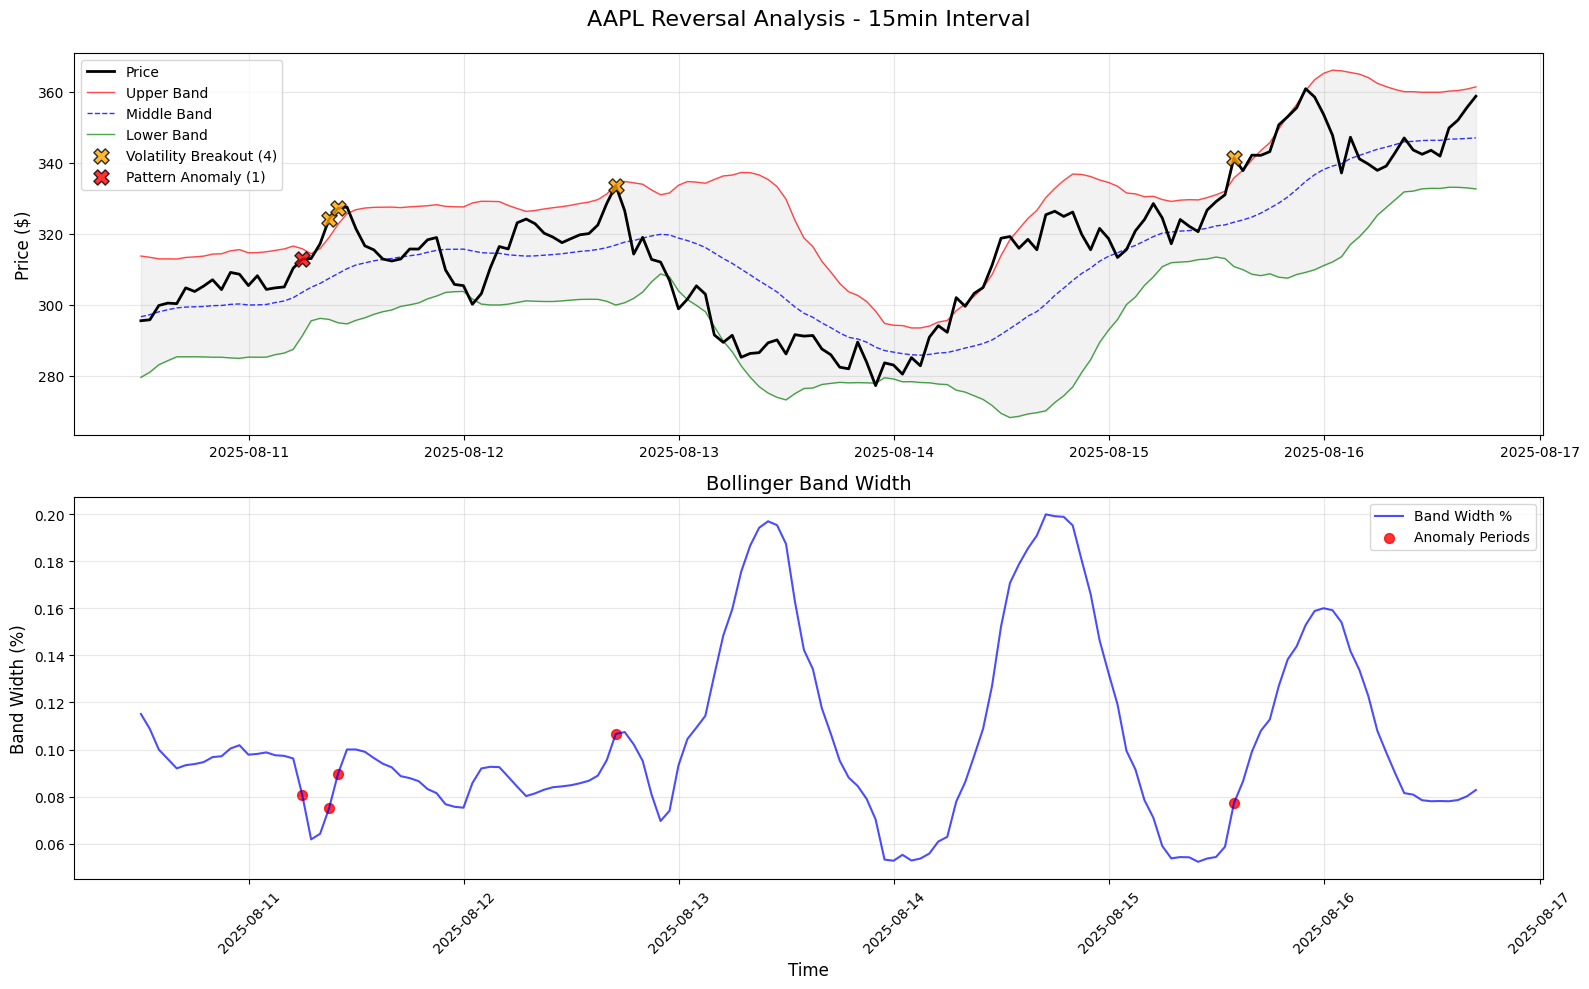

🔮 INSIGHT (15min Interval): No significant reversal patterns detected recently.
   Market appears stable within normal Bollinger Band patterns.
📊 REVERSAL STATISTICS (15min Interval):
   • Total reversal signals: 51
   • Squeeze Reversal: 11 (21.6%)
   • Breakout Reversal: 2 (3.9%)
   • Volatility Breakout: 29 (56.9%)
   • Pattern Anomaly: 9 (17.6%)

📈 Processing 60min Interval...
⬇️ Fetching data for AAPL (60min)...
❌ An error occurred during data fetching: time data '2025-07-18 07:00' does not match format '%Y-%m-%d %H:%M:%S'
⚠️ API fetch failed or insufficient data for 60min Interval. Using mock data.
🎭 Generating mock data with reversal patterns...
🔍 Running statistical reversal anomaly detection...
🔎 Reversal anomaly detection complete. Threshold: 0.2727
📊 Found 51 reversal anomalies out of 1422 data points


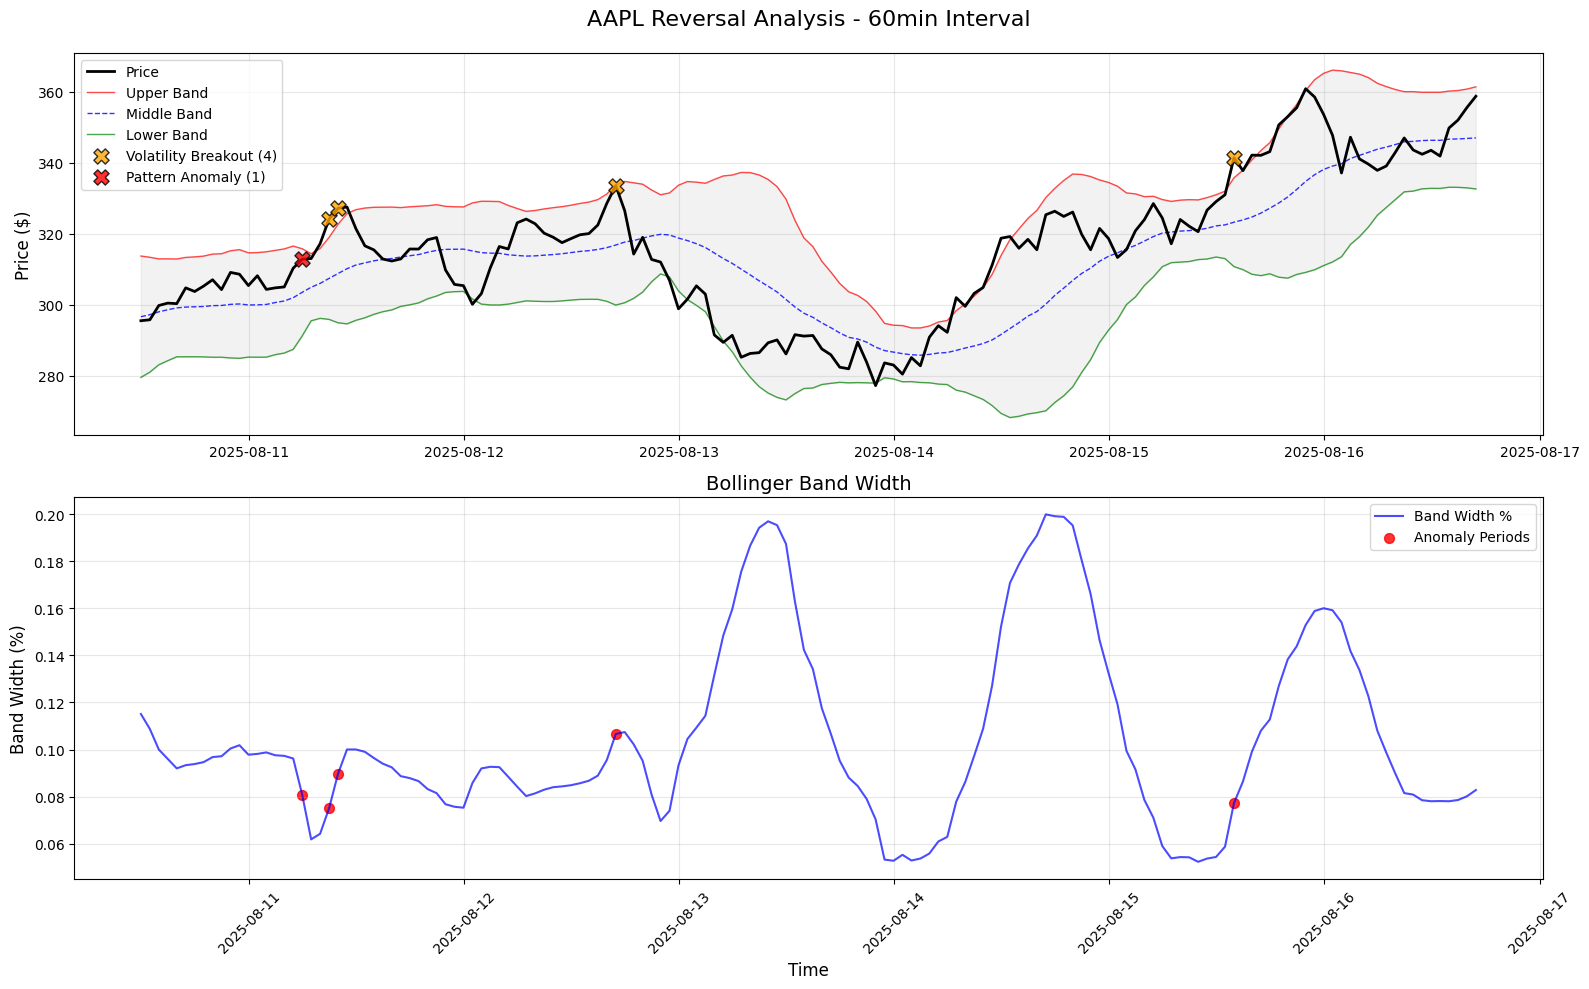

🔮 INSIGHT (60min Interval): No significant reversal patterns detected recently.
   Market appears stable within normal Bollinger Band patterns.
📊 REVERSAL STATISTICS (60min Interval):
   • Total reversal signals: 51
   • Squeeze Reversal: 11 (21.6%)
   • Breakout Reversal: 2 (3.9%)
   • Volatility Breakout: 29 (56.9%)
   • Pattern Anomaly: 9 (17.6%)

✅ ENHANCED REVERSAL ANALYSIS COMPLETE
💡 KEY: Focus on 'Breakout Reversal' and 'Squeeze Reversal' for best trading signals!
🎯 TIP: Combine with volume analysis for confirmation of reversal strength.


In [5]:
# better 
# Enhanced Trading Analyzer - Pandas-Free Version
from datetime import date, datetime, timedelta
import requests
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuration constants
SYMBOL = "AAPL"
SEQUENCE_LENGTH = 20
ALPHA_VANTAGE_API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY', 'demo')

class SimpleDataFrame:
    """Simple DataFrame replacement using native Python structures"""
    def __init__(self, data=None, index=None, columns=None):
        if data is None:
            data = {}
        
        if isinstance(data, dict):
            self.data = data
            self.columns = list(data.keys()) if columns is None else columns
        elif isinstance(data, list):
            if columns is None:
                raise ValueError("Must provide columns for list data")
            self.data = {col: [row[i] if i < len(row) else None for row in data] 
                        for i, col in enumerate(columns)}
            self.columns = columns
        
        self.index = index if index is not None else list(range(len(list(self.data.values())[0]) if self.data else 0))
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, key):
        if isinstance(key, str):
            return self.data.get(key, [])
        elif isinstance(key, list):
            return SimpleDataFrame({k: self.data[k] for k in key if k in self.data}, index=self.index)
        elif isinstance(key, slice):
            start, stop = key.start or 0, key.stop or len(self)
            new_index = self.index[start:stop]
            new_data = {col: values[start:stop] for col, values in self.data.items()}
            return SimpleDataFrame(new_data, index=new_index)
    
    def __setitem__(self, key, value):
        if isinstance(value, (list, np.ndarray)):
            self.data[key] = list(value)
        else:
            self.data[key] = [value] * len(self)
        if key not in self.columns:
            self.columns.append(key)
    
    def iloc(self, idx):
        if isinstance(idx, int):
            return {col: values[idx] for col, values in self.data.items()}
        elif isinstance(idx, slice):
            return self[idx]
    
    def tail(self, n=5):
        return self[-n:]
    
    def rolling_mean(self, column, window):
        values = self.data[column]
        result = []
        for i in range(len(values)):
            if i < window - 1:
                result.append(None)
            else:
                window_vals = [v for v in values[i-window+1:i+1] if v is not None]
                if window_vals:
                    result.append(sum(window_vals) / len(window_vals))
                else:
                    result.append(None)
        return result
    
    def rolling_std(self, column, window):
        values = self.data[column]
        means = self.rolling_mean(column, window)
        result = []
        for i in range(len(values)):
            if i < window - 1 or means[i] is None:
                result.append(None)
            else:
                window_vals = [v for v in values[i-window+1:i+1] if v is not None]
                if len(window_vals) > 1:
                    mean_val = means[i]
                    variance = sum((v - mean_val) ** 2 for v in window_vals) / len(window_vals)
                    result.append(variance ** 0.5)
                else:
                    result.append(None)
        return result
    
    def pct_change(self, column, periods=1):
        values = self.data[column]
        result = []
        for i in range(len(values)):
            if i < periods or values[i] is None or values[i-periods] is None:
                result.append(None)
            else:
                if values[i-periods] != 0:
                    result.append((values[i] - values[i-periods]) / values[i-periods])
                else:
                    result.append(None)
        return result
    
    def diff(self, column, periods=1):
        values = self.data[column]
        result = []
        for i in range(len(values)):
            if i < periods:
                result.append(None)
            else:
                if values[i] is not None and values[i-periods] is not None:
                    result.append(values[i] - values[i-periods])
                else:
                    result.append(None)
        return result
    
    def dropna(self):
        valid_indices = []
        for i in range(len(self)):
            if all(self.data[col][i] is not None for col in self.columns):
                valid_indices.append(i)
        
        new_data = {col: [values[i] for i in valid_indices] for col, values in self.data.items()}
        new_index = [self.index[i] for i in valid_indices]
        return SimpleDataFrame(new_data, index=new_index)

def calculate_reversal_features(df):
    """Calculate features that capture price reversals and band dynamics"""
    # Price momentum and reversal indicators
    df['price_momentum'] = df.pct_change('close', periods=3)
    
    # Calculate price acceleration manually
    momentum = df['price_momentum']
    acceleration = []
    for i in range(len(momentum)):
        if i == 0 or momentum[i] is None or momentum[i-1] is None:
            acceleration.append(None)
        else:
            acceleration.append(momentum[i] - momentum[i-1])
    df['price_acceleration'] = acceleration
    
    # Bollinger Band width and position
    upper, middle, lower, close = df['upper'], df['middle'], df['lower'], df['close']
    band_width = []
    price_position = []
    
    for i in range(len(df)):
        if all(x[i] is not None for x in [upper, middle, lower, close]):
            # Band width
            bw = (upper[i] - lower[i]) / middle[i] if middle[i] != 0 else 0
            band_width.append(bw)
            
            # Price position in bands
            band_range = upper[i] - lower[i]
            if band_range != 0:
                pp = (close[i] - lower[i]) / band_range
                price_position.append(pp)
            else:
                price_position.append(0.5)  # Middle position if no range
        else:
            band_width.append(None)
            price_position.append(None)
    
    df['band_width'] = band_width
    df['band_width_change'] = df.pct_change('band_width')
    df['price_position'] = price_position
    
    # Direction changes
    close_diff = df.diff('close')
    direction = [1 if x and x > 0 else -1 if x and x < 0 else 0 for x in close_diff]
    df['price_direction'] = direction
    
    direction_change = []
    for i in range(len(direction)):
        if i == 0:
            direction_change.append(0)
        else:
            direction_change.append(abs(direction[i] - direction[i-1]))
    df['direction_change'] = direction_change
    
    # Moving averages
    df['ma_5'] = df.rolling_mean('close', 5)
    df['ma_10'] = df.rolling_mean('close', 10)
    
    ma_cross = []
    ma_5, ma_10 = df['ma_5'], df['ma_10']
    for i in range(len(df)):
        if ma_5[i] is not None and ma_10[i] is not None:
            ma_cross.append(1 if ma_5[i] > ma_10[i] else -1)
        else:
            ma_cross.append(0)
    df['ma_cross'] = ma_cross
    
    ma_cross_change = []
    for i in range(len(ma_cross)):
        if i == 0:
            ma_cross_change.append(0)
        else:
            ma_cross_change.append(abs(ma_cross[i] - ma_cross[i-1]))
    df['ma_cross_change'] = ma_cross_change
    
    # Volatility
    df['volatility'] = df.rolling_std('close', 10)
    df['volatility_change'] = df.pct_change('volatility')
    
    return df

def detect_statistical_anomalies(df):
    """Simple statistical anomaly detection focused on reversals"""
    key_features = [
        'price_momentum', 'price_acceleration', 'band_width_change',
        'price_position', 'direction_change', 'ma_cross_change',
        'volatility_change'
    ]
    
    anomaly_scores = [0.0] * len(df)
    
    for feature in key_features:
        if feature not in df.data:
            continue
            
        values = df[feature]
        
        # Calculate rolling statistics
        rolling_means = []
        rolling_stds = []
        window = 20
        
        for i in range(len(values)):
            if i < window - 1:
                rolling_means.append(None)
                rolling_stds.append(None)
            else:
                window_vals = [v for v in values[i-window+1:i+1] if v is not None]
                if len(window_vals) > 1:
                    mean_val = sum(window_vals) / len(window_vals)
                    rolling_means.append(mean_val)
                    
                    variance = sum((v - mean_val) ** 2 for v in window_vals) / len(window_vals)
                    rolling_stds.append(variance ** 0.5)
                else:
                    rolling_means.append(None)
                    rolling_stds.append(None)
        
        # Calculate z-scores and add to anomaly score
        weight = 2.0 if 'change' in feature else 1.0
        
        for i in range(len(values)):
            if (values[i] is not None and rolling_means[i] is not None and 
                rolling_stds[i] is not None and rolling_stds[i] > 0):
                z_score = abs((values[i] - rolling_means[i]) / rolling_stds[i])
                if z_score > 2.0:
                    anomaly_scores[i] += weight
    
    # Normalize scores
    max_possible = sum([2.0 if 'change' in f else 1.0 for f in key_features])
    if max_possible > 0:
        anomaly_scores = [score / max_possible for score in anomaly_scores]
    
    return anomaly_scores

class EnhancedTradingAnalyzer:
    def __init__(self, api_key):
        self.api_key = api_key

    def fetch_bollinger_bands(self, symbol, interval):
        """Fetch Bollinger Bands data with timeout"""
        print(f"⬇️ Fetching data for {symbol} ({interval})...")
        try:
            bbands_params = {
                "function": "BBANDS",
                "symbol": symbol,
                "interval": interval,
                "time_period": 20,
                "series_type": "close",
                "apikey": self.api_key
            }
            response = requests.get("https://www.alphavantage.co/query", params=bbands_params, timeout=20)
            data = response.json()

            if 'Technical Analysis: BBANDS' not in data:
                print(f"❌ API Error: {data.get('Note', 'No BBANDS data found.')}")
                return None

            bbands_data = data['Technical Analysis: BBANDS']
            
            # Convert to our simple dataframe
            dates = list(bbands_data.keys())
            dates.sort()
            
            df_data = {
                'upper': [float(bbands_data[date]['Real Upper Band']) for date in dates],
                'middle': [float(bbands_data[date]['Real Middle Band']) for date in dates],
                'lower': [float(bbands_data[date]['Real Lower Band']) for date in dates]
            }
            
            df = SimpleDataFrame(df_data, index=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates])

            # Fetch price data
            price_params = {
                "function": "TIME_SERIES_INTRADAY",
                "symbol": symbol,
                "interval": interval,
                "apikey": self.api_key,
                "outputsize": "full"
            }
            price_response = requests.get("https://www.alphavantage.co/query", params=price_params, timeout=20)
            price_response_data = price_response.json()
            
            time_series_key = f'Time Series ({interval})'
            if time_series_key not in price_response_data:
                print(f"❌ Price data not available: {price_response_data.get('Note', 'Unknown error')}")
                return None
                
            price_data = price_response_data[time_series_key]
            
            # Add close prices to our dataframe
            close_prices = []
            for date in dates:
                if date in price_data:
                    close_prices.append(float(price_data[date]['4. close']))
                else:
                    close_prices.append(None)
            
            df['close'] = close_prices
            df = df.dropna()
            
            return df
            
        except requests.exceptions.Timeout:
            print("❌ API request timed out. The server is not responding.")
            return None
        except Exception as e:
            print(f"❌ An error occurred during data fetching: {e}")
            return None

    def generate_mock_data(self, days=60):
        """Generate realistic mock data with clear reversal patterns"""
        print("🎭 Generating mock data with reversal patterns...")
        
        # Generate dates
        end_date = datetime.now()
        dates = []
        current_date = end_date - timedelta(days=days)
        while current_date <= end_date:
            dates.append(current_date)
            current_date += timedelta(hours=1)
        
        np.random.seed(42)
        base_price = 150.0
        
        # Create price series with trend changes
        price_series = []
        current_price = base_price
        trend = 1
        
        for i, date in enumerate(dates):
            if i > 0 and i % 200 == 0:  # Change trend every ~200 periods
                trend *= -1  # Reverse trend
                
            # Add trend and noise
            price_change = np.random.normal(trend * 0.001, 0.015)
            current_price *= (1 + price_change)
            price_series.append(current_price)
        
        # Calculate Bollinger Bands
        window = 20
        middle_band = []
        std_values = []
        
        for i in range(len(price_series)):
            if i < window - 1:
                middle_band.append(None)
                std_values.append(None)
            else:
                window_prices = price_series[i-window+1:i+1]
                mean_price = sum(window_prices) / len(window_prices)
                variance = sum((p - mean_price) ** 2 for p in window_prices) / len(window_prices)
                std_price = variance ** 0.5
                
                middle_band.append(mean_price)
                std_values.append(std_price)
        
        upper_band = []
        lower_band = []
        
        for i in range(len(price_series)):
            if middle_band[i] is not None and std_values[i] is not None:
                upper_band.append(middle_band[i] + (2 * std_values[i]))
                lower_band.append(middle_band[i] - (2 * std_values[i]))
            else:
                upper_band.append(None)
                lower_band.append(None)
        
        df_data = {
            'upper': upper_band,
            'middle': middle_band,
            'lower': lower_band,
            'close': price_series
        }
        
        df = SimpleDataFrame(df_data, index=dates)
        return df.dropna()

    def detect_reversal_anomalies(self, df):
        """Detect anomalies focused on reversals and band dynamics"""
        required_cols = ['upper', 'middle', 'lower', 'close']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Missing required columns: {missing_cols}")
            df['anomaly'] = [False] * len(df)
            df['anomaly_score'] = [0.0] * len(df)
            df['reversal_signal'] = ['None'] * len(df)
            return df
        
        # Calculate enhanced features
        df = calculate_reversal_features(df)
        
        # Use statistical anomaly detection
        print("🔍 Running statistical reversal anomaly detection...")
        anomaly_scores = detect_statistical_anomalies(df)
        
        # Set threshold (top 15% of non-zero scores)
        non_zero_scores = [s for s in anomaly_scores if s > 0]
        if non_zero_scores:
            threshold = np.percentile(non_zero_scores, 85)
        else:
            threshold = 0.1
        
        df['anomaly_score'] = anomaly_scores
        df['anomaly'] = [score > threshold for score in anomaly_scores]
        
        # Add reversal signal classification
        df = self.classify_reversal_signals(df)
        
        anomaly_count = sum(df['anomaly'])
        print(f"🔎 Reversal anomaly detection complete. Threshold: {threshold:.4f}")
        print(f"📊 Found {anomaly_count} reversal anomalies out of {len(df)} data points")
        
        return df
    
    def classify_reversal_signals(self, df):
        """Classify the type of reversal signal"""
        reversal_signals = []
        
        for i in range(len(df)):
            if df['anomaly'][i]:
                band_width_change = df['band_width_change'][i] if i < len(df['band_width_change']) else 0
                direction_change = df['direction_change'][i] if i < len(df['direction_change']) else 0
                volatility_change = df['volatility_change'][i] if i < len(df['volatility_change']) else 0
                
                band_expanding = band_width_change and band_width_change > 0.02
                band_contracting = band_width_change and band_width_change < -0.02
                has_direction_change = direction_change and direction_change > 0
                high_volatility = volatility_change and volatility_change > 0.1
                
                if has_direction_change and band_expanding:
                    reversal_signals.append('Breakout Reversal')
                elif has_direction_change and band_contracting:
                    reversal_signals.append('Squeeze Reversal')
                elif band_expanding and high_volatility:
                    reversal_signals.append('Volatility Breakout')
                elif has_direction_change:
                    reversal_signals.append('Trend Reversal')
                else:
                    reversal_signals.append('Pattern Anomaly')
            else:
                reversal_signals.append('None')
        
        df['reversal_signal'] = reversal_signals
        return df

    def visualize_enhanced_data(self, df, interval_name):
        """Enhanced visualization with reversal signals"""
        required_cols = ['upper', 'middle', 'lower', 'close', 'anomaly', 'reversal_signal']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"❌ Cannot visualize: Missing columns {missing_cols}")
            return
            
        plt.figure(figsize=(16, 10))
        plot_df = df.tail(150)
        
        # Extract data for plotting
        plot_dates = plot_df.index
        plot_close = plot_df['close']
        plot_upper = plot_df['upper']
        plot_middle = plot_df['middle']
        plot_lower = plot_df['lower']
        plot_anomaly = plot_df['anomaly']
        plot_signals = plot_df['reversal_signal']
        
        # Main price and bands
        plt.subplot(2, 1, 1)
        plt.plot(plot_dates, plot_close, 'black', linewidth=2, label='Price', zorder=3)
        plt.plot(plot_dates, plot_upper, 'r-', alpha=0.7, linewidth=1, label='Upper Band')
        plt.plot(plot_dates, plot_middle, 'b--', alpha=0.8, linewidth=1, label='Middle Band')
        plt.plot(plot_dates, plot_lower, 'g-', alpha=0.7, linewidth=1, label='Lower Band')
        
        # Fill between bands
        plt.fill_between(plot_dates, plot_upper, plot_lower, alpha=0.1, color='gray')
        
        # Plot anomalies by type
        reversal_types = list(set(plot_signals))
        colors = ['purple', 'orange', 'red', 'cyan', 'yellow']
        
        for i, rev_type in enumerate(reversal_types):
            if rev_type != 'None':
                anomaly_dates = []
                anomaly_prices = []
                for j, (is_anomaly, signal) in enumerate(zip(plot_anomaly, plot_signals)):
                    if is_anomaly and signal == rev_type:
                        anomaly_dates.append(plot_dates[j])
                        anomaly_prices.append(plot_close[j])
                
                if anomaly_dates:
                    plt.scatter(anomaly_dates, anomaly_prices, 
                              color=colors[i % len(colors)], s=120,
                              marker='X', label=f'{rev_type} ({len(anomaly_dates)})', 
                              zorder=5, alpha=0.8, edgecolors='black', linewidth=1)
        
        plt.title(f'{SYMBOL} Reversal Analysis - {interval_name}', fontsize=16, pad=20)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        
        # Band width subplot
        plt.subplot(2, 1, 2)
        band_width = [(u - l) / m if m != 0 else 0 for u, m, l in 
                      zip(plot_upper, plot_middle, plot_lower)]
        plt.plot(plot_dates, band_width, 'blue', alpha=0.7, label='Band Width %')
        
        # Highlight anomaly periods
        anomaly_dates = []
        anomaly_widths = []
        for j, is_anomaly in enumerate(plot_anomaly):
            if is_anomaly:
                anomaly_dates.append(plot_dates[j])
                anomaly_widths.append(band_width[j])
        
        if anomaly_dates:
            plt.scatter(anomaly_dates, anomaly_widths, 
                       color='red', s=50, alpha=0.8, label='Anomaly Periods')
        
        plt.title('Bollinger Band Width', fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Band Width (%)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

    def run_enhanced_analysis(self, symbol="AAPL"):
        """Run the enhanced reversal-focused analysis"""
        print(f"🚀 LAUNCHING ENHANCED REVERSAL ANALYSIS FOR {symbol} 🚀")
        print("🎯 Focused on: Price Reversals + Band Expansion/Contraction")
        print("=" * 80)
        
        global SYMBOL
        SYMBOL = symbol
        
        for interval in ["15min", "60min"]:
            interval_name = f"{interval} Interval"
            print(f"\n📈 Processing {interval_name}...")
            
            df = self.fetch_bollinger_bands(symbol, interval)
            if df is None or len(df) < (SEQUENCE_LENGTH + 20):
                print(f"⚠️ API fetch failed or insufficient data for {interval_name}. Using mock data.")
                df = self.generate_mock_data()

            df_with_anomalies = self.detect_reversal_anomalies(df)
            
            self.visualize_enhanced_data(df_with_anomalies, interval_name)
            
            # Enhanced insights
            recent_data = df_with_anomalies.tail(24)
            recent_anomalies_indices = [i for i, anomaly in enumerate(recent_data['anomaly']) if anomaly]
            
            if recent_anomalies_indices:
                signal_counts = {}
                for i in recent_anomalies_indices:
                    signal = recent_data['reversal_signal'][i]
                    signal_counts[signal] = signal_counts.get(signal, 0) + 1
                
                print(f"🔮 REVERSAL INSIGHTS ({interval_name}):")
                for signal_type, count in signal_counts.items():
                    print(f"   • {signal_type}: {count} occurrence(s)")
                
                if recent_anomalies_indices:
                    last_idx = recent_anomalies_indices[-1]
                    last_signal = recent_data['reversal_signal'][last_idx]
                    last_time = recent_data.index[last_idx].strftime('%Y-%m-%d %H:%M')
                    print(f"   • Latest signal: {last_signal} at {last_time}")
                    print(f"   🚨 TRADING ALERT: Monitor for potential trend changes!")
            else:
                print(f"🔮 INSIGHT ({interval_name}): No significant reversal patterns detected recently.")
                print("   Market appears stable within normal Bollinger Band patterns.")
            
            # Statistics
            total_anomalies = sum(df_with_anomalies['anomaly'])
            signal_distribution = {}
            for anomaly, signal in zip(df_with_anomalies['anomaly'], df_with_anomalies['reversal_signal']):
                if anomaly:
                    signal_distribution[signal] = signal_distribution.get(signal, 0) + 1
            
            print(f"📊 REVERSAL STATISTICS ({interval_name}):")
            print(f"   • Total reversal signals: {total_anomalies}")
            for signal_type, count in signal_distribution.items():
                percentage = (count / total_anomalies) * 100 if total_anomalies > 0 else 0
                print(f"   • {signal_type}: {count} ({percentage:.1f}%)")
        
        print("\n" + "=" * 80)
        print("✅ ENHANCED REVERSAL ANALYSIS COMPLETE")
        print("💡 KEY: Focus on 'Breakout Reversal' and 'Squeeze Reversal' for best trading signals!")
        print("🎯 TIP: Combine with volume analysis for confirmation of reversal strength.")

# --- Main Execution ---
if __name__ == "__main__":
    print("🔧 Initializing Enhanced Reversal Analyzer...")
    analyzer = EnhancedTradingAnalyzer(ALPHA_VANTAGE_API_KEY)
    
    # Run enhanced analysis
    analyzer.run_enhanced_analysis(SYMBOL)